# What is this notebook about
This notebook will splice a given image/mask of 900x900 resolution into a specified resolution that is friendly for CNNs. Typical CNNs are trained on sizes like 224x224, 256x256, 299x299.

> For this project, we shall use size <b>224x224</b>, one of the most popular training sizes for most CNNs like ImageNet, Resnet, VGG16, VGG19

Afterwards, we will generate the train-test set and save the resulting images in .npy format for faster loading

> Please ensure you have run the notebook `2_create_mask.ipynb` before this

# Setup and Imports

In [27]:
import os
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm 
from PIL import Image 

import fiona
import rasterio
from rasterio.plot import show as show_raster, reshape_as_raster, reshape_as_image

import tensorflow as tf

AttributeError: type object 'h5py.h5.H5PYConfig' has no attribute '__reduce_cython__'

# Global Variables

In [2]:
ROOT_DIR = Path('')
PATH_DATA_FULL = ROOT_DIR/'data_full/AOI_11_Rotterdam'
PATH_DATA_PROJECT = ROOT_DIR/'data_project'

In [ ]:
# An index, used just for inspecting one specific file
INSPECT_IDX = 0

# Set seed for repeatable results
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Helper Functions

### inspect_tif(tif_file)
Used to check out the basic features of a given tif file

In [4]:
def inspect_tif(tif_file):
    print("Count: {}".format(tif_file.count))

    # check the geospatial boundary of this image file, the corners of the image
    print("Corners: {}".format(tif_file.bounds))

    # getting dimensions, in map units of meters
    width = tif_file.bounds.right - tif_file.bounds.left
    height = tif_file.bounds.top - tif_file.bounds.bottom
    print("Width: {}, Height: {}".format(width, height))

    # getting pixel dimensions
    width_px = tif_file.width
    height_px = tif_file.height
    print("Pixels - Width: {}, Height: {}".format(width_px, height_px))

    # how many meters to a pixel
    width_ratio = width/width_px
    height_ratio = height/height_px
    print("m to px Ratio - Width: {}, Height: {}".format(width_ratio, height_ratio))

    # get coordinate reference system
    print("Coordinate Reference System: {}".format(tif_file.crs))

    # Get coordinates of top left and bottom right points since there is a coordinate reference system attached to this file
    topleft = tif_file.transform * (0,0)
    bottomright = tif_file.transform * (width, height)

    print("Top left coordinates: {}, Bottom right coordinates: {}".format(topleft, bottomright))

    # get basic metadata of this geotif file
    print("Metadata of geotiff file")
    print(tif_file.meta)     # can also use satdat.profile instead of satdat.meta

    # get number of bands by listing indices. count in the metadata refers to the number of bands
    print("Indexes: {}".format(tif_file.indexes))

### plot_bands(raster)
Plots out the individual bands of a raster file

In [5]:
def plot_bands(raster):
    channels = raster.read().shape[0]
    
    # PAN
    if channels == 1:
        show_raster(raster)
    
    # RGB
    elif channels == 3:
        fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
        show_raster((raster, 1), ax=axr, cmap='Reds', title='red channel')
        show_raster((raster, 2), ax=axg, cmap='Greens', title='green channel')
        show_raster((raster, 3), ax=axb, cmap='Blues', title='blue channel')
        plt.show()
    
    # Multispectral
    elif channels == 4:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(21,7))
        show_raster((raster, 1), ax=ax1, cmap='Reds', title='channel 1')
        show_raster((raster, 2), ax=ax2, cmap='Greens', title='channel 2')
        show_raster((raster, 3), ax=ax3, cmap='Blues', title='channel 3')
        show_raster((raster, 4), ax=ax4, cmap='Oranges', title='channel 4')
        plt.show()      
        
    else:
        print("Wrong format")

### plot_raster_mask(raster, mask, index)
To plot a raster and a mask side by side

In [6]:
def plot_raster_mask(raster, mask, index):    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
    show_raster(raster, ax=ax1)
    show_raster(mask, ax=ax2)
    
    print("Index: {}".format(index))
    plt.show()        

### plot_img_mask(img, mask, index)
To plot an image and a mask (traditional RGB) side by side

In [7]:
def plot_img_mask(img, mask, index):    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
    ax1.imshow(img)
    ax2.imshow(mask)
    
    print("Index: {}".format(index))
    plt.show()        

# Splitting images into 224x224
Every individual image-mask pair will be split the same way, into groups of 224x224 image-mask pairs that composite into the same bigger picture

### Grab the necessary files
We will be splitting the PS-RGB images and masks as a pair

In [8]:
PATH_IMG = PATH_DATA_FULL/'PS-RGB'
PATH_MASK = PATH_DATA_FULL/'mask'

fnames_img = next(os.walk(PATH_IMG))[2]
fnames_mask = next(os.walk(PATH_MASK))[2]

for fnames in [fnames_img, fnames_mask]:
    fnames.sort()

print(fnames_img[0])
print(fnames_mask[0])

SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8679.tif
SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.tif


Index: 0


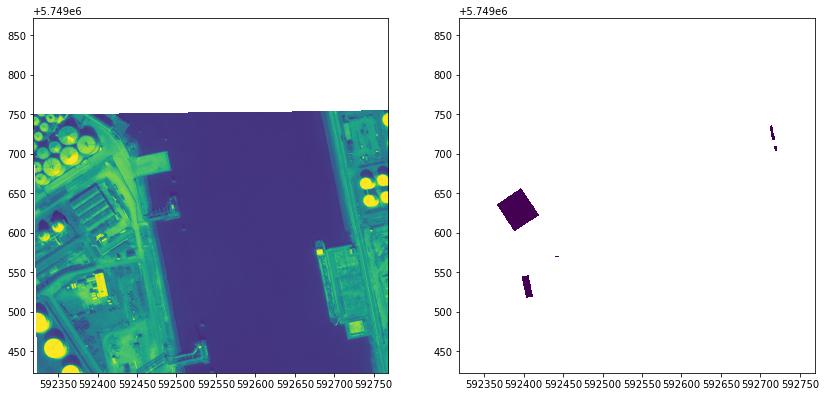

In [9]:
sample_img = rasterio.open(PATH_IMG/fnames_img[INSPECT_IDX])
sample_mask = rasterio.open(PATH_MASK/fnames_mask[INSPECT_IDX])
plot_raster_mask(sample_img, sample_mask, INSPECT_IDX)

In [10]:
print(sample_img.read().shape)
print(sample_mask.read().shape)

(3, 900, 900)
(1, 900, 900)


### Make the necessary directories to store image result

In [11]:
PATH_TILE_IMG = PATH_DATA_FULL/'tile_img'
PATH_TILE_MASK = PATH_DATA_FULL/'tile_mask'
for path in [PATH_TILE_IMG, PATH_TILE_MASK]:
    if not os.path.exists(path):
        os.makedirs(path)

### Tiling the image
We know that the input img-mask pairs are both 900x900. We shall tile these images to tiles of size 224x224 each, which gives a 896x896 composite when stitched together. Therefore we will remove a border of 2 pixels around the original 900x900 image to give a 896x896 image that can be neatly tiled into a 4x4 grid

> Using the Image library to open an image will reduce its datatype from uint16 to uint8, but this is ok since we want to work with traditional images in the interest of computational time (spacenet provides very high resolution ones)

In [29]:
def tiling(img_name, path_img, path_img_save):
    img = Image.open(path_img/img_name)
    img_height, img_width = img.size

    # img.crop argument sequence: (left, top, right, bottom)
    img_cropped = img.crop((2, 2, img_width-2, img_height-2))

    # top to bottom
    tile_id = 1
    for ver in range(1, 897, 224):
        top = ver
        bottom = ver+223

        # left to right
        for hor in range(1, 897, 224):
            left = hor
            right = hor+223

            img_tile = img_cropped.crop((left, top, right, bottom))
            img_tile_name = img_name[:-4] + "_subtile_" + str(tile_id) + img_name[-4:]
            img_tile.save(path_img_save/img_tile_name)

            tile_id += 1

In [37]:
for x, fname in tqdm(enumerate(fnames_img), total=len(fnames_img)):
    tiling(fname, PATH_IMG, PATH_TILE_IMG)

print("Img tiles generated")

100%|█████████████████████████████████████████████████████████████████████████| 3401/3401 [00:00<00:00, 1706727.44it/s]

Img tiles generated


In [38]:
for x, fname in tqdm(enumerate(fnames_mask), total=len(fnames_mask)):
    tiling(fname, PATH_MASK, PATH_TILE_MASK)

print("Mask tiles generated")

100%|█████████████████████████████████████████████████████████████████████████| 3401/3401 [00:00<00:00, 1705503.10it/s]

Mask tiles generated


Index: 9883


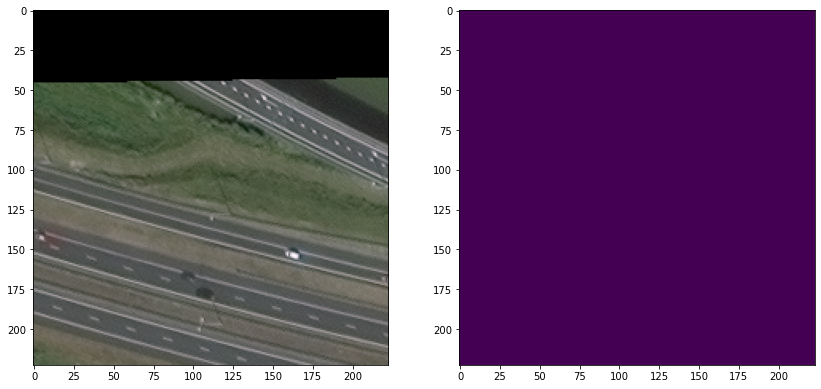

Index: 17999


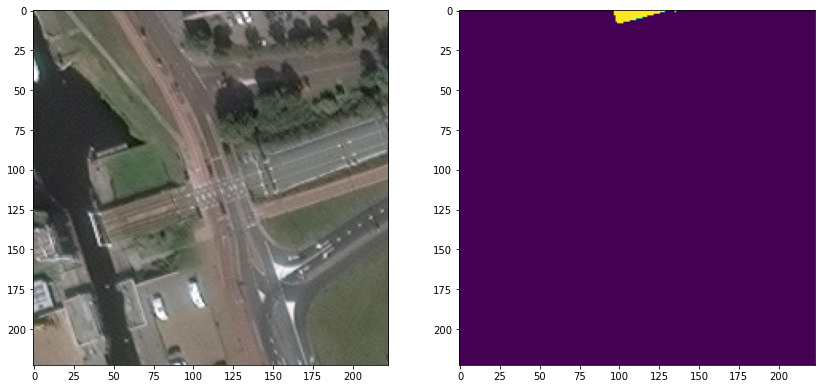

Index: 5563


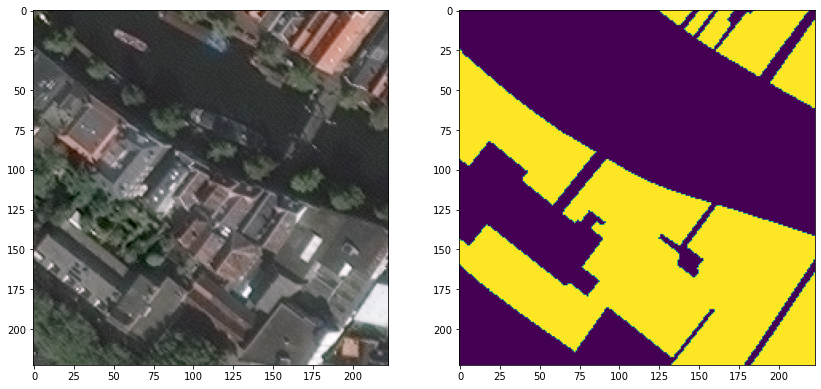

Index: 33752


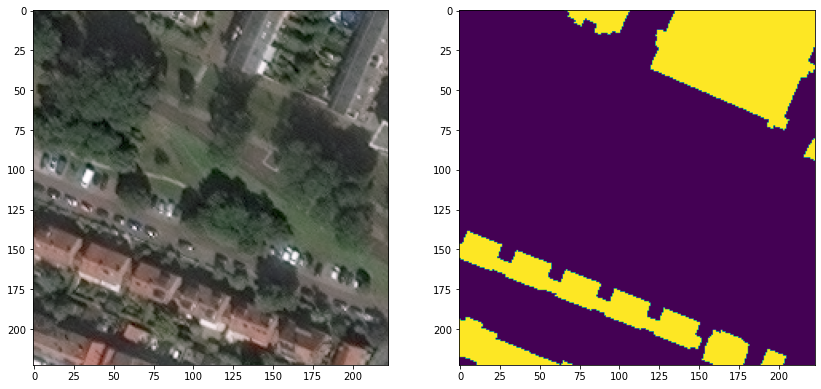

In [12]:
fnames_tile_img = next(os.walk(PATH_TILE_IMG))[2]
fnames_tile_img.sort()

fnames_tile_mask = next(os.walk(PATH_TILE_MASK))[2]
fnames_tile_mask.sort()


for i in range(4):
    index = np.random.randint(0, len(fnames_tile_img))
    sample_tile_img = Image.open(PATH_TILE_IMG/fnames_tile_img[index])
    sample_tile_mask = Image.open(PATH_TILE_MASK/fnames_tile_mask[index])
    plot_img_mask(sample_tile_img, sample_tile_mask, index)

# Train-Test Split
Now we need to split our data into training, and testing groups. We will randomly select indexes from the tiled images and masks and save into a .npy binary file for faster future loading

### Make the necessary directories to store train-test binaries

In [25]:
PATH_TRAIN = PATH_DATA_PROJECT/'train'
PATH_TEST = PATH_DATA_PROJECT/'test'

PATH_TRAIN_IMG = PATH_TRAIN/'img'
PATH_TRAIN_MASK = PATH_TRAIN/'mask'
PATH_TEST_IMG = PATH_TEST/'img'
PATH_TEST_MASK = PATH_TEST/'mask'

for path in [PATH_DATA_PROJECT, PATH_TRAIN, PATH_TEST, PATH_TRAIN_IMG, PATH_TRAIN_MASK, PATH_TEST_IMG, PATH_TEST_MASK]:
    if not os.path.exists(path):
        os.makedirs(path)

### Set and create an index binary file
We will use these indexes to continually load in the same files for train/test. The indexes are saved as a record

In [31]:
# set the various sizes we want to use 
SIZE_ALL = len(fnames_tile_img)    # total number of tiled images/masks = 3401*16 = 54416
SIZE_TRAIN = int(SIZE_ALL*0.7)     # 70% of available data         
SIZE_TEST = SIZE_ALL-SIZE_TRAIN    # 30% of available data    


# Generate the indexes that we will be using for train and test 
ALL_IDX = np.arange(SIZE_ALL)

TRAIN_IDX = np.random.choice(ALL_IDX, SIZE_TRAIN, replace=False)
TRAIN_IDX.sort()

ALL_IDX_2 = np.setdiff1d(ALL_IDX, TRAIN_IDX)

TEST_IDX = np.random.choice(ALL_IDX_2, SIZE_TEST, replace=False)
TEST_IDX.sort()


# Save the indexes
np.save(PATH_TRAIN/('TRAIN_IDX_'+str(SIZE_TRAIN)), TRAIN_IDX)
np.save(PATH_TEST/('TEST_IDX_'+str(SIZE_TEST)), TEST_IDX)
print('Generating and saving TRAIN/TEST indexes')


# Load it back out
TRAIN_IDX = np.load(PATH_TRAIN/('TRAIN_IDX_'+str(SIZE_TRAIN)+'.npy'))
TEST_IDX = np.load(PATH_TEST/('TEST_IDX_'+str(SIZE_TEST)+'.npy'))

print("TRAIN/TEST indexes loaded")
print("TRAIN_IDX:", PATH_TRAIN/('TRAIN_IDX_'+str(SIZE_TRAIN)+'.npy'))
print("TEST_IDX:", PATH_TEST/('TEST_IDX_'+str(SIZE_TEST)+'.npy'))

Generating and saving TRAIN/TEST indexes
TRAIN/TEST indexes loaded
TRAIN_IDX: data_project\train\TRAIN_IDX_38091.npy
TEST_IDX: data_project\test\TEST_IDX_16325.npy


### Create the binaries for image and mask, for train and test, based on indexes

In [53]:
# convert to scalar array for indexing
all_img_ids = np.array(fnames_tile_img)
all_mask_ids = np.array(fnames_tile_mask)


# get the ids/filenames that we need, based on the random index allocation to avoid grouping 
# X are image files, Y are mask files 
X_train_ids = all_img_ids[TRAIN_IDX]
X_train_ids.sort()
Y_train_ids = all_mask_ids[TRAIN_IDX]
Y_train_ids.sort()

X_test_ids = all_img_ids[TEST_IDX]
X_test_ids.sort()
Y_test_ids = all_mask_ids[TEST_IDX]
Y_test_ids.sort()


# save each image as a np array in .npy file format
for n, id in tqdm(enumerate(X_train_ids), total=len(X_train_ids), position=0, leave=True):
    img = np.array(Image.open(PATH_TILE_IMG/id), dtype=np.uint8)
    np.save(PATH_TRAIN_IMG/id[:-4], img.ravel())
print('Finished formatting X_train')  

for n, id in tqdm(enumerate(Y_train_ids), total=len(Y_train_ids), position=0, leave=True):
    img = np.array(Image.open(PATH_TILE_MASK/id), dtype=np.bool)
    np.save(PATH_TRAIN_MASK/id[:-4], img.ravel())
print('Finished formatting Y_train')  

for n, id in tqdm(enumerate(X_test_ids), total=len(X_test_ids), position=0, leave=True):
    img = np.array(Image.open(PATH_TILE_IMG/id), dtype=np.uint8)
    np.save(PATH_TEST_IMG/id[:-4], img.ravel())
print('Finished formatting X_test')  

for n, id in tqdm(enumerate(Y_test_ids), total=len(Y_test_ids), position=0, leave=True):
    img = np.array(Image.open(PATH_TILE_MASK/id), dtype=np.bool)
    np.save(PATH_TEST_MASK/id[:-4], img.ravel())
print('Finished formatting Y_test')

print('Generated and saved TRAIN/TEST data')

# Load it back out by going for the filename 

  0%|▏                                                                             | 76/38091 [00:00<01:39, 383.82it/s]

Finished formatting X_train


  0%|                                                                              | 15/16325 [00:00<01:53, 143.96it/s]

Finished formatting Y_train


  0%|                                                                              | 19/16325 [00:00<01:28, 184.30it/s]

Finished formatting X_test


100%|███████████████████████████████████████████████████████████████████████████| 16325/16325 [02:07<00:00, 128.13it/s]


Finished formatting Y_test
Generated and saved TRAIN/TEST data


# We've done the train-test split, now what?
Now that we have finished our train-test split and saved picture as a .npy file, we can achieve much faster loading speeds.

Note that at this point, we can delete the entirety of our original data in the directory `data_full` if we are desperate for space. We will not be interacting with it anymore since we have everything that we need in `data_project`